This program is free software: you can redistribute it and/or modify it under the terms of the GNU General Public License as published by the Free Software Foundation, either version 3 of the License, or (at your option) any later version.

This program is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU General Public License for more details.

You should have received a copy of the GNU General Public License along with this program. If not, see <https://www.gnu.org/licenses/>. 

In [1]:
using DrWatson
@quickactivate "FastDysonSolver"

In [2]:
using Revise
using BenchmarkTools
includet("../src/BlasSelector.jl")
includet("../src/AdaptativeSampler.jl")

In [3]:
@show Threads.nthreads()
@show Threads.ngcthreads()

Threads.nthreads() = 20
Threads.ngcthreads() = 20


20

In [4]:
using LinearAlgebra
select_BLAS()
using HssMatrices
using NonEquilibriumGreenFunction

using GLMakie
using Colors
using ColorSchemes
using LaTeXStrings

using Symbolics
using SymbolicNumericIntegration
using DSP

Intel CPU detected


In [5]:
includet("./../src/Junction.jl")

In [6]:
function setup_figure()
    prl_width = 3.38583
    size = 170 .* (prl_width, 1 * prl_width)
    return Figure(size=size, fontsize=18)
end

setup_figure (generic function with 1 method)

In [7]:
function symbolicAverage(f,T)
    @variables tau
    return integrate(f(tau)/T, (tau, 0, T), detailed=false, symbolic=true)
end

symbolicAverage (generic function with 1 method)

In [8]:
using Parameters

function base_δt()
    return 0.05
end

@with_kw struct SteadyStateProblem
    V::Float64
    Γ::Float64 
    T::Float64
    δt::Float64 = base_δt()
end

function getBeta()
    return 100
end

function phase_difference(V)
    @variables tau, t
    expr = integrate(2*V(tau), (tau, 0, t), detailed=false, symbolic=true)
    δϕ = build_function(expr, t, expression=Val{false})
    return δϕ
end
function fixed_voltage_parameters( problem::SteadyStateProblem )
    δϕ_left = phase_difference(t->problem.V/2)
    δϕ_right = phase_difference(t->problem.V/2)
    return JunctionParameters(δt=problem.δt, T=problem.T, ϕl=t -> -δϕ_left(t) , ϕr=t -> δϕ_right(t), Δ=1, Γl=problem.Γ, Γr=problem.Γ, β=getBeta(), τ = 200*problem.T , ε_τ = 0.1,n = 2)
end
function getAverage_JosepshonFrequency( problem::SteadyStateProblem )
    @variables tau
    return  integrate(V(tau) / (pi * T), (tau, 0, T), detailed=false, symbolic=true)
end
function getAverage_JosepshonFrequency(V_L,V_R,T)
    return abs(getAverage_JosepshonFrequency(t->(V_L(t)+V_R(t)),T))
end
function single_run_current(problem::SteadyStateProblem)
    p = fixed_voltage_parameters(problem)
    return single_run_current(p)
end
function extract_dc(I,problem::SteadyStateProblem)
    p = fixed_voltage_parameters(problem)
    return extract_dc(I,p)
end
function axis(problem::SteadyStateProblem)
    return axis(fixed_voltage_parameters(problem))
end

axis (generic function with 2 methods)

In [9]:
using NonEquilibriumGreenFunction.AdaptativeRichardson
function evaluate_current_raw(V, dt; Γ=10)
    Tj = pi / V
    problem = SteadyStateProblem(V=V, Γ=Γ, T=200, δt=dt)
    r = single_run_current(problem)
    dc_current = pi / 2 * extract_dc(r[:I], problem)
    return dc_current
end
function evaluate_current(V, alpha=1, beta=1; Γ=10)
    Tj = pi / V
    dt = min(alpha * Tj, beta / Γ)
    return adaptative_richardson(h -> evaluate_current_raw(V, h, Γ=Γ), dt, AdaptativeConfig(rtol=1e-2, atol=1e-2,
        verbose=true,
        max_pointsA=5, max_pointsB=5, max_total_points=15,
        max_time= 200))
end

evaluate_current (generic function with 3 methods)

In [10]:
beta = 1
#@show evaluate_current(0.10, 0.3, beta; Γ = 0.25)
#@show evaluate_current(1., 0.3, beta; Γ = 0.25)
#@show evaluate_current(0.10, 0.3, beta; Γ = 10)
#@show evaluate_current(1., 0.3, beta; Γ = 10)

1

In [11]:
function analyze_voltage(V,alpha = 0.3; Γ = 10)
    Tj = pi / V
    println("Tj = $Tj")
    println("1/Gamma = $(1 / Γ)")
    dt = alpha * min(Tj,1/Γ)
    @show dt
    problem = SteadyStateProblem(V = V, Γ = Γ, T = 200, δt = dt)
    @time r = single_run_current(problem)
    ωj_filter = get_ωj_filter(fixed_voltage_parameters(problem))
    f = lines(axis(problem), r[:I])
    lines!(axis(problem), ωj_filter(r[:I]))
    println("DC Component: $(pi / 2 * extract_dc(r[:I], problem))")
    return f
end

analyze_voltage (generic function with 2 methods)

Tj = 1.5707963267948966
1/Gamma = 0.1
dt = 0.05
 29.516424 seconds (23.50 M allocations: 44.977 GiB, 26.85% gc time, 58.63% compilation time: 2% of which was recompilation)
DC Component: 3.7692402053056795


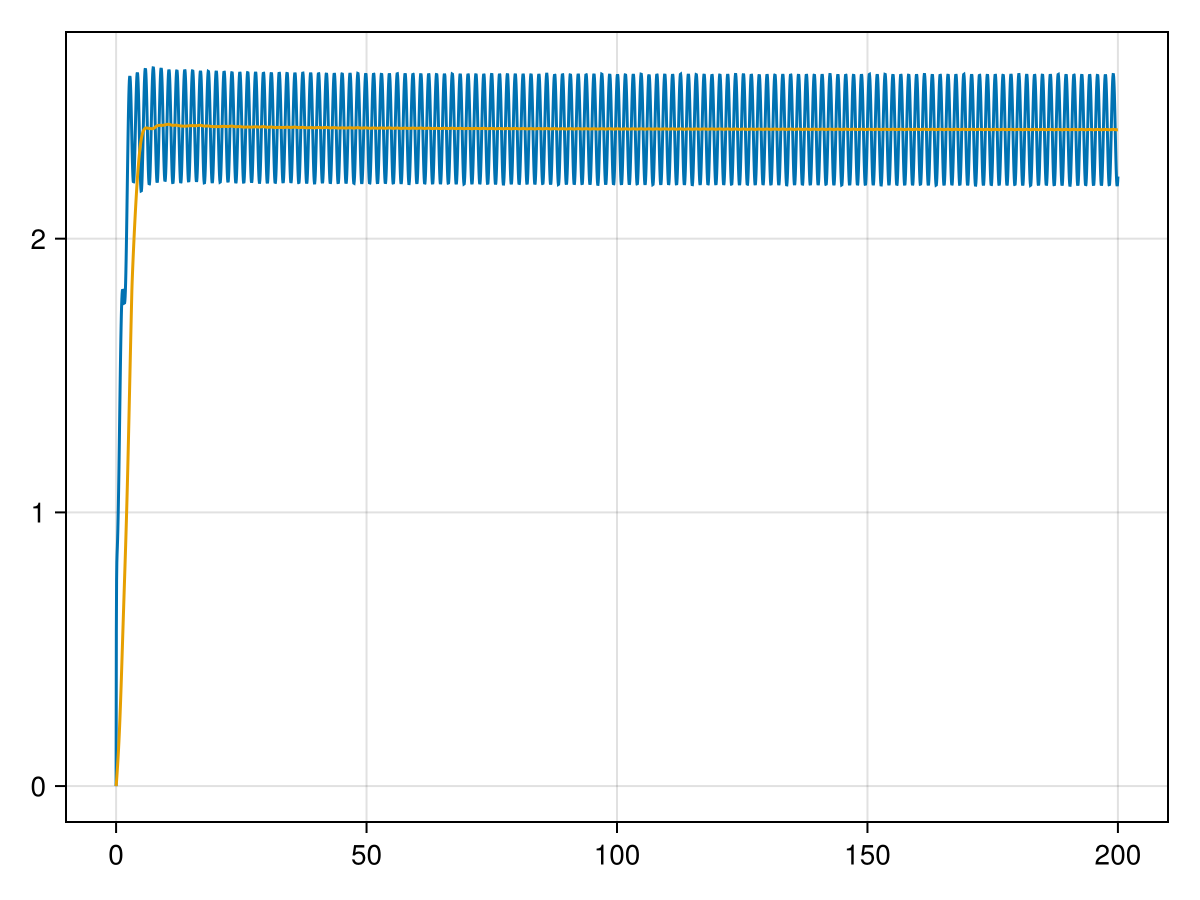

In [12]:
analyze_voltage(2, 0.5; Γ = 10)

In [13]:
#analyze_voltage(2, 1; Γ = 10)

In [14]:
#analyze_voltage(2, 0.3; Γ = 0.25)

In [15]:
#analyze_voltage(2, 0.2; Γ = 0.25)

In [16]:
10*0.5^7

0.078125

In [17]:
using ProgressMeter
using NonEquilibriumGreenFunction.AdaptativeRichardson

function compute_IV(; Γ = 1,  V_min = 0.1, V_max = 2.5, n_samples)
    println("V_min =  $V_min, V_max = $V_max", ", Γ = $Γ")
    prog = Progress(n_samples, desc = "Adaptive Sampling")
    number_of_initial_points = min(7, n_samples ÷ 2)
    candidate_first_sample = vcat([V_max/i for i in LinRange(1,10,number_of_initial_points - 1)],[V_min])
    first_sample = sort(candidate_first_sample[V_min .<= candidate_first_sample .< V_max])
    function sample_idc(V,δt)
        Tj = pi/V
        problem = SteadyStateProblem(V = V, Γ = Γ, T = max(200, 20*Tj), δt = δt)
        simulation_results,_ = produce_or_load(problem,datadir("simulations", "steady_state_current"), tag = false, verbose = false) do config
            r = single_run_current(problem)
            return Dict("I"=>r[:I],"problem"=>problem)
        end
        dc_current = extract_dc(simulation_results["I"],simulation_results["problem"])
        return dc_current
    end
    cfg = AdaptativeConfig(rtol=1e-2, atol=1e-2, max_pointsA=5, max_pointsB=5, max_total_points=10)
    function sample_idc_richardson(V)
        Tj = pi/V
        dt0 = min(0.3*Tj, 0.5/Γ)
        result = adaptative_richardson(h -> sample_idc(V, h), dt0, cfg)
        result.converged || @warn "Did not converge for V = $V and Γ = $Γ"
        result_dc = result.u0_est 
        next!(prog)
        return result_dc
    end
    V,I = adaptive_sampling(sample_idc_richardson, (V_min, V_max), n_samples, initial_points = first_sample)
    return V,I
end

compute_IV (generic function with 1 method)

In [18]:
list_Γ_full = [0.25,0.5,1,2]
n_samples_per_Γ = Dict(0.25 => 40, 0.5 => 40, 1 => 40, 2 => 10, 10 => 10)
default_n_samples = 30 
IV_results_full = [ compute_IV(Γ = Γ, n_samples = get(n_samples_per_Γ, Γ, default_n_samples)) for Γ in list_Γ_full]

V_min =  0.1, V_max = 2.5, Γ = 0.25


Adaptive Sampling 100%|██████████████████████████████████| Time: 0:16:03


V_min =  0.1, V_max = 2.5, Γ = 0.5


Adaptive Sampling 100%|██████████████████████████████████| Time: 0:30:45


V_min =  0.1, V_max = 2.5, Γ = 1.0


Adaptive Sampling 100%|██████████████████████████████████| Time: 1:22:50


V_min =  0.1, V_max = 2.5, Γ = 2.0


Adaptive Sampling 100%|██████████████████████████████████| Time: 1:31:56


4-element Vector{Tuple{Vector{Float64}, Vector{Float64}}}:
 ([0.1, 0.25, 0.30487804878048785, 0.3477515243902439, 0.36918826219512196, 0.37990663109756095, 0.390625, 0.40017832880434784, 0.4097316576086957, 0.4192849864130435  …  1.1941964285714286, 1.2946428571428572, 1.6964285714285714, 1.8973214285714284, 1.9475446428571428, 1.997767857142857, 2.047991071428571, 2.0982142857142856, 2.299107142857143, 2.5], [6.464929465880345e-6, 0.0029077716543977838, 0.013403669098644797, 0.009362747105309772, 0.008288796611542916, 0.008832939573135237, 0.007991500371855732, 0.022386345693794413, 0.04604692166382062, 0.05100640964222693  …  0.13526468251936877, 0.13376331568401753, 0.12318248389290051, 0.12797486546384748, 0.1294742868727408, 0.13749925586459608, 0.16034380688561542, 0.1852477522557223, 0.28951101074294566, 0.3966441085727376])
 ([0.1, 0.25, 0.26371951219512196, 0.2774390243902439, 0.2842987804878049, 0.2911585365853659, 0.2980182926829269, 0.30487804878048785, 0.3263147865853659, 

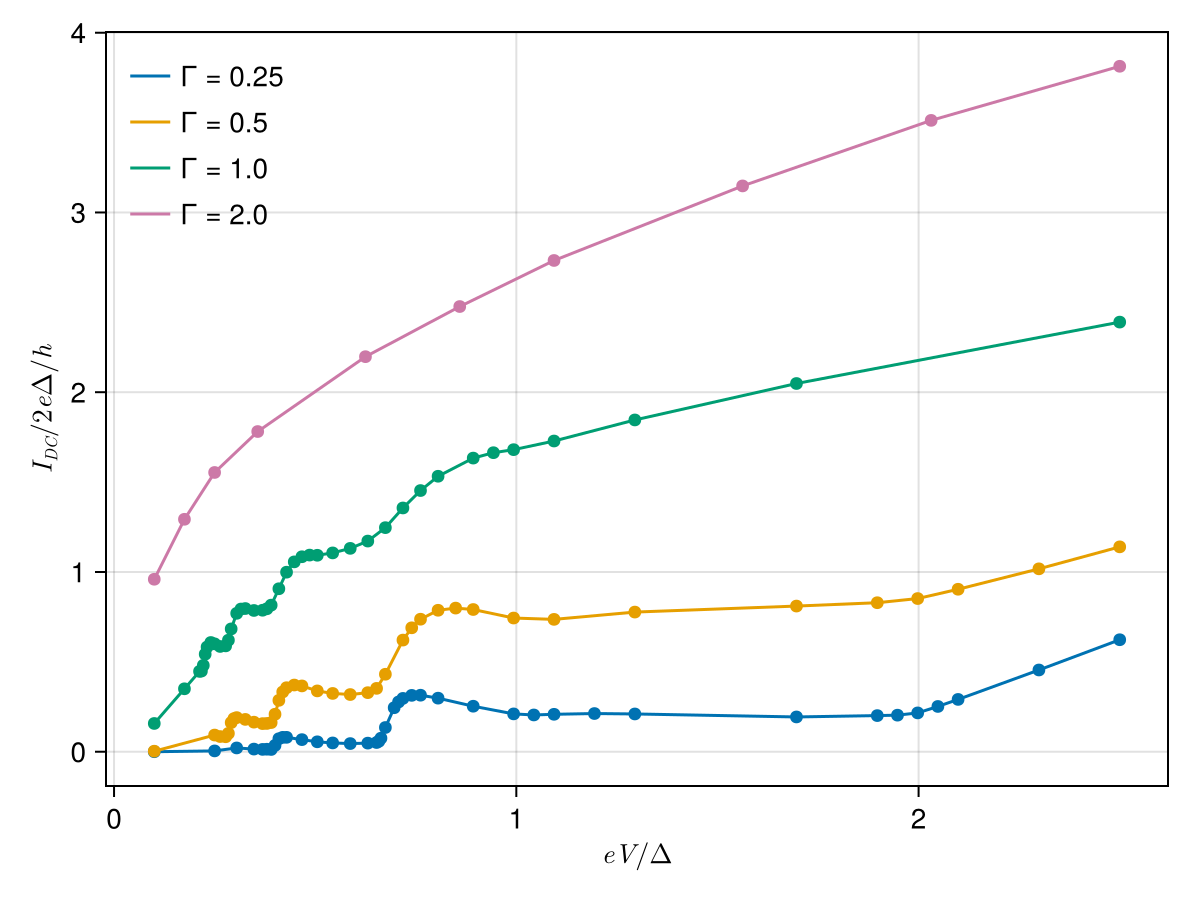

In [19]:
f = Figure()
ax = Axis(f[1, 1],
        xlabel=L"eV/\Delta",
        ylabel=L"I_{DC}/2e\Delta/h")
for i in 1:length(IV_results_full)
        Idc = IV_results_full[i][2]
        V = IV_results_full[i][1]
        lines!(ax, V, pi/2*Idc, label = "Γ = $(list_Γ_full[i])")
        scatter!(ax, V, pi/2*Idc)
end
axislegend(position=:lt, framevisible=false, labelsize=14)
save("../IV.pdf", f, pt_per_unit=1)
f